In [33]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [8]:
# Part A
Hitters = load_data("Hitters")
Hitters = Hitters.dropna()
Hitters['Salary'] = np.log(Hitters['Salary'])
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,6.551080,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,6.774224,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,5.953243,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,6.866933,A


In [6]:
# Part B
model = MS(Hitters.columns.drop('Salary'), intercept=False)
D = model.fit_transform(Hitters)
feature_names = list(D.columns)
X = np.asarray(D)

In [12]:
X_train, X_test, y_train, y_test = skm.train_test_split(X,
                                                        Hitters['Salary'],
                                                        test_size=63,
                                                        random_state=0)

In [53]:
# Part C and D
train_MSE = []
test_MSE = []
for learning_rate in [0.0001,0.001, 0.01,0.1,1]:
    boost_hitters = GBR(n_estimators=1000, # number of trees 
                       learning_rate=learning_rate, 
                       max_depth=3,
                       random_state=0)
    boost_hitters.fit(X_train, y_train)
    
    y_hat = boost_hitters.predict(X_train)
    train_MSE.append(np.mean((y_hat-y_train)**2))
    
    y_hat = boost_hitters.predict(X_test)
    test_MSE.append(np.mean((y_hat-y_test)**2))

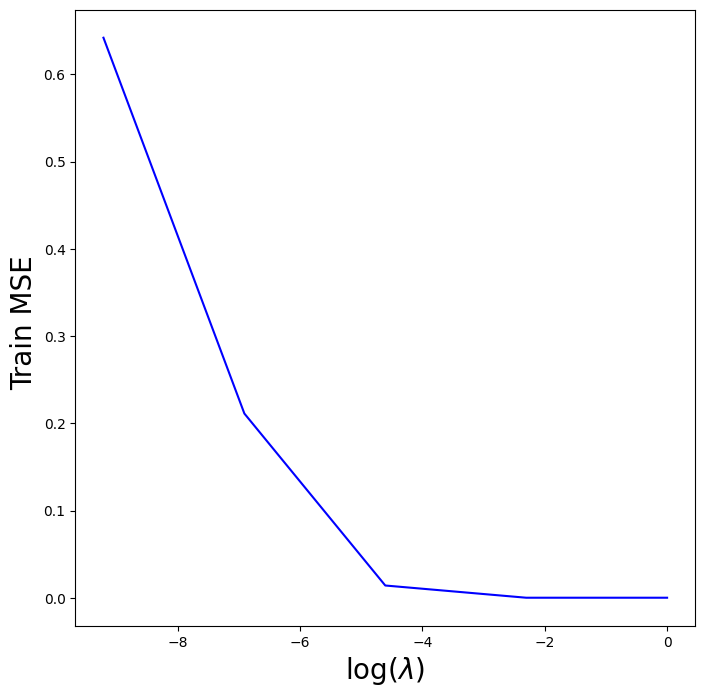

In [54]:

ax = subplots(figsize=(8,8))[1]
ax.plot(np.log([0.0001,0.001, 0.01,0.1,1]),
        train_MSE,
        'b');
ax.set_ylabel('Train MSE ', fontsize=20);
ax.set_xlabel('$\log(\lambda)$', fontsize=20);

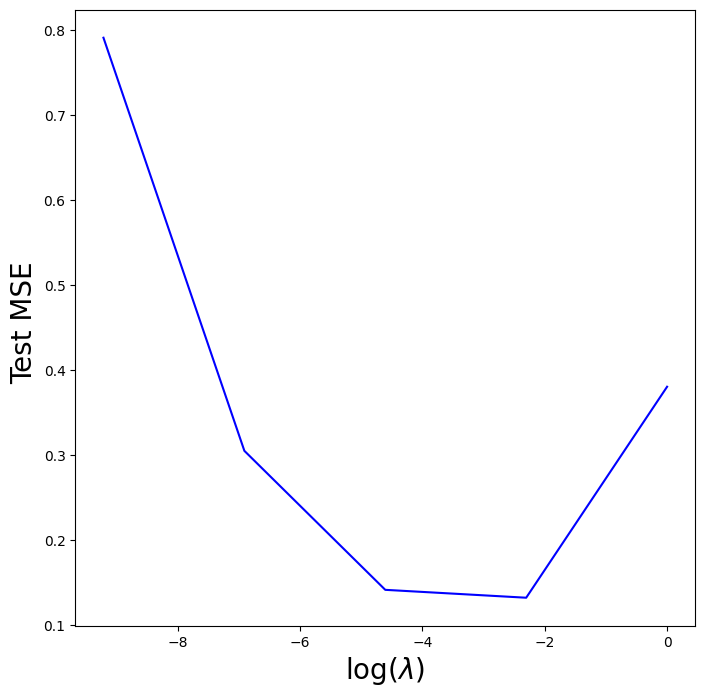

In [56]:
# Part D
ax = subplots(figsize=(8,8))[1]
ax.plot(np.log([0.0001,0.001, 0.01,0.1,1]),
        test_MSE,
        'b');
ax.set_ylabel('Test MSE ', fontsize=20);
ax.set_xlabel('$\log(\lambda)$', fontsize=20);

In [60]:
# Part F
feature_imp = pd.DataFrame(
    {'importance': boost_hitters.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by ='importance', ascending=False)

,importance
CAtBat,0.570111
Hits,0.140016
CRBI,0.111639
Walks,0.032442
Assists,0.020281
Years,0.019363
AtBat,0.017936
Errors,0.016817
PutOuts,0.014688
CRuns,0.012376


In [61]:
# Part G
bag_hitters = RF(max_features=X_train.shape[1], random_state=0)
bag_hitters.fit(X_train, y_train)

RandomForestRegressor(max_features=19, random_state=0)

0.13997995650333214

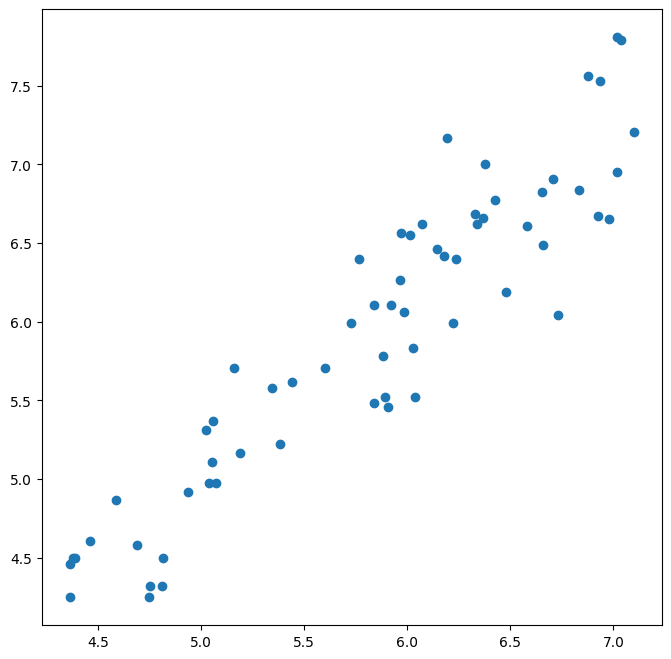

In [62]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_hitters.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)